### COM361 &mdash; Introdução a Otimização &mdash; 2022, Prof. Amit ###

# Event triggered social media chatter model - Julia implementation #

#### Gabriel José Souza e Silva (gabriel.jsss@poli.ufrj.br), Matheus Marinatto (marinattomatheus@poli.ufrj.br)


### Contents ###

1. Introduction and problem description
2. Mathematical modeling
3. Control techniques
    1. Optimal control
        1. Optimal control without cost constraints
        2. Optimal control with budget constraints
    2. Optimal control with cost function aiming to minimize $t_{eq}$
        1. Optimal control with cost function aiming to minimize $t_{eq}$ without cost constraints
        2. Optimal control with cost function aiming to minimize $t_{eq}$ with budget constraints
    3. Model Predictive Control (MPC)
        1.  Model predictive control without cost constraints
        2. Model predictive control with cost constraints
4. Results
5. Conclusion
6. Bibliography

## 1. Introduction and problem description ##

This project's goal is to describe and explore a social marketing-based model for information spread, testing different control techniques so to determine which one provides better results. An important constraint for most marketing campaigns nowadays is the advertising cost, therefore a key goal for dispersing a message is to do that as efficiently and possible respecting budget and time constraints. From that, many optimization problems can be formulated. The following question, described in [1] gives the reason for such models to exist:

> At a high level, how does an organization sell to someone? Typically, individuals or groups (like marketing agencies) are enlisted as message spreaders who broadcast that information in a variety of formats including billboards, social media posts, and television advertisements.
> 

So in order to sell, it's necessary to spread information and the further question would be **how to maximize sells (and information spread) while minimizing costs**.

In [1], the approach to design an advertising model starts from the well established Vidale-Wolfe marketing model with some tweaks to better handle the social media dynamics. Quoting [2]:

> The Vidale-Wolfe marketing model is a first-order, linear, nonhomogeneous ordinary differential equation (ODE) where the forcing term is proportional to advertising expenditure. With an initial response in sales as the initial condition, the solution of the initial value problem is straightforward for a first undergraduate ODE course.
> 

Mathematically, this model is described as follows:

 $\frac{dS(t)}{dt} = \beta u(t)[M(t) - S(t)] - \delta S(t)$

where

- S(t) → Sales at time t;
- M(t) → Market size at time t;
- $\beta$ → Advertising constant;
- $\delta$ → Rate of brand sale decay;
- $u(t)$ → Control action at time t.

Most of the terms above are self-explanatory but $\beta$, which is described in [1] as “[…] the rate of decay of brand sale given no active advertising.”

From that, the Event-triggered Social Media Chatter Model is derived by doing the following:

1. Normalizing Vidale-Wolfe's model by setting $M(t) = 1$;
2. Breaking $\beta$ into two other constants:
    1. $\beta_1$ → the social marketing campaign constant;
    2. $\beta_2$ → the social interaction constant;
3. Generalizing the sales term $S(t)$ to an information spread value $X_t$.

In [1] the meaning of these constants is explained in the following paragraph

> The effectiveness of social marketing is affected by dynamic resource spending and promotion over the network to convince people to purchase a product, uphold a social or political movement, or join in an activity. The social marketing constant can be associated with a traditional advertising campaign or an event that triggers similar social media interest. Once people become exposed to an advertisement and decide to share the message, the social interaction constant may be viewed as the natural tendency of the social media network to advertise internally through posts, tweets, and likes without external influences and advertising.
> 

The final mathematical model is 

$$
dX_t = \beta_1 u(t)[1 - X_t] + \beta_2 [1 - X_t] X_t - \delta X_t
$$

or visually 

![Model](./assets/model.png)

The final definition to be presented is the concept of socio-equilibrium threshold. It basically describes the equilibrium level of social media chatter after the control (promotion) goes to 0 or mathematically

$$
X_{eqb} = 1 - \frac{\delta}{\beta_2}
$$

In [1], $\beta_2$ is multiplied by a factor k, but in this project the value of k will be embedded in $\beta_2$. Finally, the “[…] goal of social media marketing is to increase peoples’ attention and interest beyond the natural equilibrium point through the control action of spending resources on ads…” and at the same time minimizing the associated costs.



## 2. Mathematical model ##

During a marketing campaign, **the goal is to achieve social craze status as fast as possible while keeping costs as low as possible**. From that the optimization problem will be derived. The cost function for the Event-triggered Social Media Chatter Model is defined in [1] as 

$$
J = \int_{0}^{t_f}  [u^2(t) + (x-x_d)^2 + \lambda] dt
$$

where 

- $\lambda$  → weight placed on time. Meaning the importance of how long it takes to get to equilibrium;
- $x_d$ → desired amount of activity.

when there's no need to maintain $x_d$, $u(t)= 0$. Now the mentioned equations will be discretized, so they can be used in future simulations:

- Event-triggered Social Media Chatter Model:

$$
x(t+1) - x(t) = \beta_1 u(t)[1 - x(t)] + \beta_2 [1 - x(t)] x(t) - \delta x(t)
$$

- Cost function:

$$
J = \sum_{t=0}^{T_F}(u^2(t) + (x(t) - x_d(t))^2 + \lambda)
$$

- Equilibrium point:

$$
X_{eqb} = 1 - \frac{\delta}{\beta_2}
$$

Gathering these equations, the optimization problem can be formulated as

$$
\begin{aligned}\underset{u}{\text{minimize}}\qquad& J(u, x) \\\text{subjected to:}\qquad& u_i \ge 0 && i=1,\dots,m\\& x_{i+1} = x_i + \beta_1 u_i[1 - x_i] + \beta_2 [1 - x_i] x_i - \delta x_i \\& x_i \ge 0\end{aligned}
$$

More constraints may be added according to the control technique used. The constants used are defined in the cell below, following the same as used in the snipet on page 151 of [1].

The first formulation proposed tries to get to the equibilibrium minimizing the associated expenses. However, another goal could be to get to the $X_{eqb}$ as fast as possible. For this second goal proposed in this project, the objective function can be reduced to

$$
J = \sum_{t=0}^{T_F}(x(t) - X_{eqb})^2
$$


In [1]:
#dependencies

import Pkg; 
Pkg.add("JuMP");
Pkg.add("Clp");
Pkg.add("PyPlot");
Pkg.add("Ipopt");
Pkg.add("PrettyTables");

@time using Clp;
@time using JuMP;
@time using PyPlot;
@time using Ipopt;
@time using PrettyTables;


    Updating registry at `~/.julia/registries/General.toml`


   Resolving package versions...


  No Changes to `~/.julia/environments/v1.8/Project.toml`
  No Changes to `~/.julia/environments/v1.8/Manifest.toml`


   Resolving package versions...


  No Changes to `~/.julia/environments/v1.8/Project.toml`
  No Changes to `~/.julia/environments/v1.8/Manifest.toml`


   Resolving package versions...


  No Changes to `~/.julia/environments/v1.8/Project.toml`
  No Changes to `~/.julia/environments/v1.8/Manifest.toml`


   Resolving package versions...


  No Changes to `~/.julia/environments/v1.8/Project.toml`
  No Changes to `~/.julia/environments/v1.8/Manifest.toml`


   Resolving package versions...


  No Changes to `~/.julia/environments/v1.8/Project.toml`
  No Changes to `~/.julia/environments/v1.8/Manifest.toml`


  8.608024 seconds (9.04 M allocations: 640.379 MiB, 3.56% gc time, 11.19% compilation time: 94% of which was recompilation)


  0.522843 seconds (510.98 k allocations: 36.289 MiB, 7.80% compilation time: 100% of which was recompilation)


 12.828859 seconds (9.71 M allocations: 509.779 MiB, 4.23% gc time, 56.69% compilation time: 64% of which was recompilation)


  0.877162 seconds (765.81 k allocations: 40.803 MiB, 2.81% gc time, 84.21% compilation time: 100% of which was recompilation)


  0.843643 seconds (982.29 k allocations: 62.350 MiB, 3.02% gc time)


In [2]:
δ = 0.1; #forgetting factor
β1 = 0.1; #spreading constant
β2 = 0.15; #social spreading
λ = 1; #time cost weight
xEquilibrium = 1-(δ/β2);
ρβ1 = 0.02;
ρβ2 = 0.03;
ρδ = 0.025;

function getTimeXeqReached(x)
    for t in 1:numberOfIterations
        if x[t] >= 0.33
            return t;
        end
    end
    return 0;
end;

<h2> 3.1 Optimal control </h2>

<h3> 3.1.1 Optimal control without cost constraints </h3>

In [3]:
function optimalControl()
    m = Model(Ipopt.Optimizer);
    set_silent(m);
    @variable(m, xOptimalControl[1:numberOfIterations] >= 0);        
    @variable(m, uOptimalControl[1:numberOfIterations] >= 0);

    for t in 1:numberOfIterations-1
        @constraint(m, xOptimalControl[t+1] == xOptimalControl[t] + β1*uOptimalControl[t]*(1 - xOptimalControl[t]) + β2*(1 - xOptimalControl[t])*xOptimalControl[t] - δ*xOptimalControl[t]);
    end

    @constraint(m, sum(xOptimalControl) >= 0);
    @constraint(m, sum(uOptimalControl) >= 0);
    @constraint(m, xOptimalControl[1] == 0) #initial point


    @objective(m, Min, sum(
        uOptimalControl .^2 .+ (xOptimalControl .- xEquilibrium).^2 .+ λ
    ));
    optimize!(m);
    return JuMP.objective_value.(m), JuMP.value.(xOptimalControl), JuMP.value.(uOptimalControl), sum(JuMP.value.(uOptimalControl))
end;


******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit https://github.com/coin-or/Ipopt
******************************************************************************

101.08874588996284


[-2.818722160738183e-40, 0.03143742192612366, 0.05916806739835122, 0.08380467839066263, 0.10582232339851363, 0.12559605468638763, 0.1434268599765247, 0.15955993436529997, 0.1741977870907215, 0.18750979834242631, 0.19963928951106827, 0.21070882249925718, 0.22082421915895611, 0.23007764372431538, 0.2385499913558608, 0.24631275755364787, 0.25342951558751126, 0.2599570954456325, 0.2659465337092212, 0.2714438463052314, 0.27649066331001065, 0.28112475553555605, 0.28538047559871765, 0.2892891309004579, 0.29287930196352224, 0.29617711655897844, 0.299206487752443, 0.30198932224134356, 0.3045457040034386, 0.3068940572357245, 0.30905129175803814, 0.31103293343145, 0.3128532416557598, 0.31452531563096203, 0.3160611907699571, 0.3174719264153173, 0.31876768582721826, 0.3199578092616985, 0.321050880839748, 0.3220547898118308, 0.32297678674430996, 0.3238235350899966, 0.32460115855171345, 0.3253152846030484, 0.32597108449259987, 0.32657331002560824, 0.3271263273888703, 0.32763414826040815, 0.3281004584

sys:1: UserWarning: Matplotlib is currently using agg, which is a non-GUI backend, so cannot show the figure.


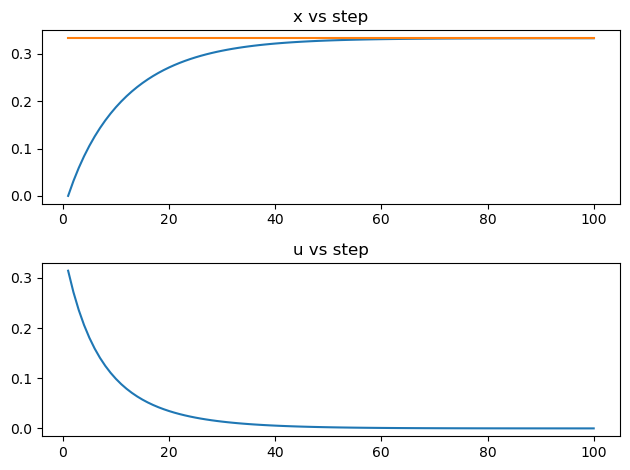

In [4]:
####### exporting variables for further analysis ########
numberOfIterations = 100;
costOptimalControlResult, xOptimalControlResult, uOptimalControlResult, controlAmountOptimalControlResult = optimalControl()
println(costOptimalControlResult);
println(xOptimalControlResult);
println(uOptimalControlResult);
println(controlAmountOptimalControlResult);
data311 = [controlAmountOptimalControlResult getTimeXeqReached(xOptimalControlResult)]

##### simple plot #######
clf(); #required for vscode on mac 
fig = plt.figure();

ax1 = fig.add_subplot(2, 1, 1);
ax1.title.set_text("x vs step");
plt.plot(range(1, numberOfIterations), xOptimalControlResult);
plt.plot(range(1, numberOfIterations), xEquilibrium .* ones(numberOfIterations));

ax2 = fig.add_subplot(2, 1, 2);
ax2.title.set_text("u vs step");
plt.plot(range(1, numberOfIterations), uOptimalControlResult);

fig.tight_layout();
show()
gcf()

<h3> 3.1.2 Optimal control with budget constraints </h3>

In [5]:
function optimalControlWithCostConstraints()
    m = Model(Ipopt.Optimizer);
    set_silent(m);
    numberOfIterations = 100;
    @variable(m, xOptimalControlLimitedCosts[1:numberOfIterations] >= 0);        
    @variable(m, uOptimalControlLimitedCosts[1:numberOfIterations] >= 0);

    for t in 1:numberOfIterations-1
        @constraint(m, xOptimalControlLimitedCosts[t+1] == xOptimalControlLimitedCosts[t] + β1*uOptimalControlLimitedCosts[t]*(1 - xOptimalControlLimitedCosts[t]) + β2*(1 - xOptimalControlLimitedCosts[t])*xOptimalControlLimitedCosts[t] - δ*xOptimalControlLimitedCosts[t]);
    end

    @constraint(m, uOptimalControlLimitedCosts[numberOfIterations] == 0);
    @constraint(m, sum(xOptimalControlLimitedCosts) >= 0);
    @constraint(m, sum(uOptimalControlLimitedCosts) >= 0);

    @constraint(m, xOptimalControlLimitedCosts[1] == 0) #prevent explosion
    @constraint(m, uOptimalControlLimitedCosts[1] <= 1) #prevent explosion

    ##### introduce max possible control input ###########################
    @constraint(m, sum(uOptimalControlLimitedCosts) <= 2.5)
    @constraint(m, uOptimalControlLimitedCosts .<= 0.1)
    ##### introduce max possible control input ###########################

    advertisingCost = @expression(m, sum(uOptimalControlLimitedCosts .^2 .+ (xOptimalControlLimitedCosts .- xEquilibrium).^2 .+ λ)) #prevent explosion
    @objective(m, Min, advertisingCost);
    optimize!(m);

    return JuMP.objective_value.(m), JuMP.value.(xOptimalControlLimitedCosts), JuMP.value.(uOptimalControlLimitedCosts), sum(JuMP.value.(uOptimalControlLimitedCosts));
end;

101.37193031857568
[-5.389835944387888e-41, 0.01000000090487954, 0.020385001821357877, 0.031138070508043507, 0.04223815724468943, 0.053660075046262065, 0.06537456826583153, 0.07734847659510692, 0.08954499831083532, 0.10192405285267549, 0.11444273862795475, 0.12705587755549752, 0.13971663356426234, 0.15237718835431643, 0.1649894544960686, 0.17750580357421655, 0.18987978427184937, 0.2016516603314117, 0.21238976465353812, 0.222197259961078, 0.2311641250022107, 0.23936942386328666, 0.2468830896554149, 0.2537673387686519, 0.2600778031023568, 0.2658644453470899, 0.27117230610800147, 0.2760421197107902, 0.2805108266914788, 0.2846120043812253, 0.2883762320510623, 0.2918314033465915, 0.29500299590762363, 0.2979143059056543, 0.30058665357619, 0.30303956454979436, 0.3052909308032337, 0.3073571542911372, 0.30925327572702194, 0.3109930905208752, 0.31258925351868927, 0.31405337390451105, 0.3153961014001839, 0.31662720471861894, 0.3177556430828727, 0.3187896315076987, 0.3197367004466675, 0.3206037503

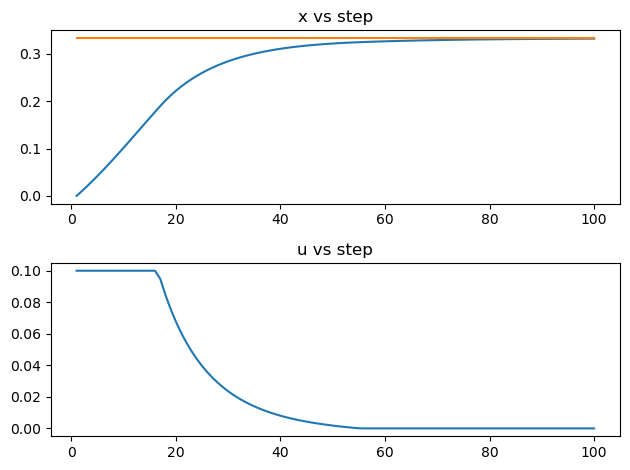

In [6]:
####### exporting variables for further analysis ########
costOptimalControlLimitedCostsResult, xOptimalControlLimitedCostsResult, uOptimalControlLimitedCostsResult, controlAmountOptimalControlLimitedCostsResult = optimalControlWithCostConstraints();
println(costOptimalControlLimitedCostsResult);
println(xOptimalControlLimitedCostsResult);
println(uOptimalControlLimitedCostsResult);
println(controlAmountOptimalControlLimitedCostsResult);
data312 = [controlAmountOptimalControlLimitedCostsResult, getTimeXeqReached(xOptimalControlLimitedCostsResult)]

##### simple plotting #######
clf(); #required for vscode on mac 
fig = plt.figure();

ax1 = fig.add_subplot(2, 1, 1);
ax1.title.set_text("x vs step");
plt.plot(range(1, numberOfIterations), xOptimalControlLimitedCostsResult);
plt.plot(range(1, numberOfIterations), xEquilibrium .* ones(numberOfIterations));

ax2 = fig.add_subplot(2, 1, 2);
ax2.title.set_text("u vs step");
plt.plot(range(1, numberOfIterations), uOptimalControlLimitedCostsResult);

fig.tight_layout();
show()
gcf()

## 3.2 Optimal control with cost function aiming to minimize $t_{eqb}$ ##

In the problems formulated above, a maximum advertising time has been established and the goal is to get to the $X_{eqb}$ using the minum amount of resources (control input). However, another problem could be formulated with the goal to reach $X_{eqb}$ and fast as possible regarless of the cost.

### 3.2.1 Optimal control min $t_{eqb}$ goal without cost constraints ###

In [7]:
function fastestEquilibriumControl()
    m = Model(Ipopt.Optimizer);
    set_silent(m);
    numberOfIterations = 100;
    @variable(m, xFastestEquilibrium[1:numberOfIterations] >= 0);        
    @variable(m, uFastestEquilibrium[1:numberOfIterations] >= 0);

    for t in 1:numberOfIterations-1
        @constraint(m, xFastestEquilibrium[t+1] == xFastestEquilibrium[t] + β1*uFastestEquilibrium[t]*(1 - xFastestEquilibrium[t]) + β2*(1 - xFastestEquilibrium[t])*xFastestEquilibrium[t] - δ*xFastestEquilibrium[t]);
    end

    @constraint(m, uFastestEquilibrium[numberOfIterations] == 0);
    @constraint(m, xFastestEquilibrium[numberOfIterations] == xEquilibrium);
    @constraint(m, sum(xFastestEquilibrium) >= 0);
    @constraint(m, sum(uFastestEquilibrium) >= 0);

    @constraint(m, xFastestEquilibrium[1] == 0) #prevent explosion

    @objective(m, Min, sum(
        sum((xFastestEquilibrium .- xEquilibrium).^ 2)
    ));
    optimize!(m);

    return JuMP.objective_value.(m), JuMP.value.(xFastestEquilibrium), JuMP.value.(uFastestEquilibrium), sum(JuMP.value.(uFastestEquilibrium));
end;

0.11111123718690193
[6.2017094556093224e-43, 0.33319620264406236, 0.33321199927132045, 0.3332226871833235, 0.33323136915169066, 0.3332388676786683, 0.3332455341298953, 0.3332515576181232, 0.3332570552923721, 0.3332621069690754, 0.333266770879035, 0.3332710917275568, 0.3332751051989774, 0.33327884065175706, 0.33328232282171116, 0.3332855729481195, 0.33328860954715217, 0.33329144896070767, 0.33329410575710405, 0.3332965930310141, 0.33329892263306354, 0.3333011053491548, 0.3333031510430227, 0.333305068771372, 0.33330686687823324, 0.333308553073316, 0.3333101344978571, 0.333311617780565, 0.33331300908562345, 0.3333143141542535, 0.3333155383409969, 0.33331668664562775, 0.3333177637414121, 0.33331877400028803, 0.3333197215154278, 0.3333206101215574, 0.33332144341334, 0.3333222247620785, 0.3333229573309456, 0.3333236440889209, 0.33332428782358337, 0.3333248911528862, 0.33332545653602375, 0.333325986283483, 0.3333264825663619, 0.3333269474250238, 0.33332738277714985, 0.33332779042524313, 0.333

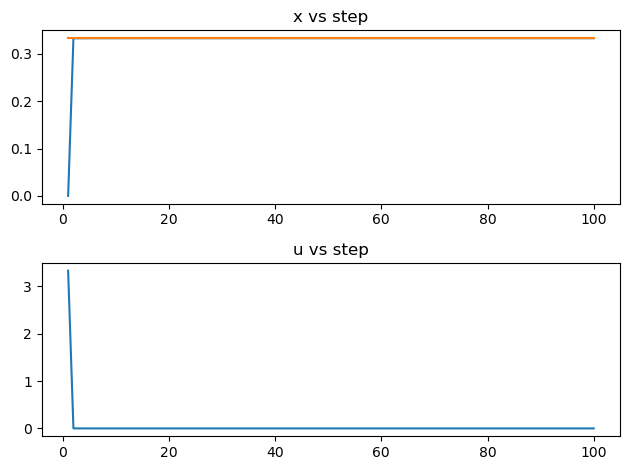

In [8]:
####### exporting variables for further analysis ########
costFastestEquilibriumResult, xFastestEquilibriumResult, uFastestEquilibriumResult, controlAmountFastestEquilibriumResult = fastestEquilibriumControl()
println(costFastestEquilibriumResult);
println(xFastestEquilibriumResult);
println(uFastestEquilibriumResult);
println(controlAmountFastestEquilibriumResult);
data321 = [controlAmountFastestEquilibriumResult getTimeXeqReached(xFastestEquilibriumResult)]

##### plotting #######
clf(); #required for vscode on mac 
fig = plt.figure();

ax1 = fig.add_subplot(2, 1, 1);
ax1.title.set_text("x vs step");
plt.plot(range(1, numberOfIterations), xFastestEquilibriumResult);
plt.plot(range(1, numberOfIterations), xEquilibrium .* ones(numberOfIterations));

ax2 = fig.add_subplot(2, 1, 2);
ax2.title.set_text("u vs step");
plt.plot(range(1, numberOfIterations), uFastestEquilibriumResult);

fig.tight_layout();
show()
gcf()


### 3.2.2 Optimal control min $t_{eqb}$ goal with cost constraints ###

1.1468870541442837
[-1.1262625283707916e-39, 0.010000000762280633, 0.020385001516896116, 0.031138070021296267, 0.04223815655418643, 0.053660074129665745, 0.06537456710023028, 0.07734847515750186, 0.08954499657897512, 0.1019240508065446, 0.11444273625255011, 0.1270558748463057, 0.13971663053888575, 0.152377185079899, 0.16498945116580566, 0.17750580079820566, 0.1898797855808032, 0.20206682583519184, 0.21402484683480652, 0.22571484304357264, 0.23710135480289243, 0.24815284615605493, 0.2588419770677837, 0.26914576758359177, 0.27904565263736486, 0.2885272876453133, 0.29046649692399673, 0.2923342263012907, 0.2941320576753576, 0.29586162183131065, 0.2975245972190606, 0.29912270192201285, 0.3006576850985535, 0.30213131874154575, 0.30354538994563485, 0.30490169373507703, 0.3062020264637381, 0.3074481797824804, 0.3086419351608155, 0.3097850589446631, 0.310879297928698, 0.3119263754194384, 0.31292798776363395, 0.31388580131547655, 0.3148014498155899, 0.3156765321545633, 0.31651261049392876, 0.317

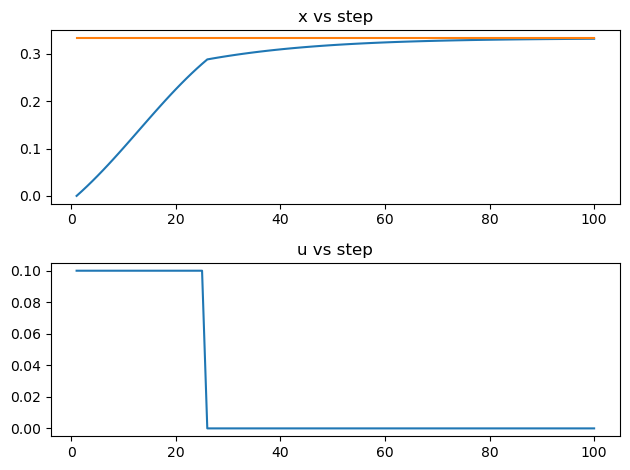

In [9]:
function fastestEquilibriumControlWithCostLimit()
    m = Model(Ipopt.Optimizer);
    set_silent(m);
    numberOfIterations = 100;
    @variable(m, xFastestEquilibrium[1:numberOfIterations] >= 0);        
    @variable(m, uFastestEquilibrium[1:numberOfIterations] >= 0);

    for t in 1:numberOfIterations-1
        @constraint(m, xFastestEquilibrium[t+1] == xFastestEquilibrium[t] + β1*uFastestEquilibrium[t]*(1 - xFastestEquilibrium[t]) + β2*(1 - xFastestEquilibrium[t])*xFastestEquilibrium[t] - δ*xFastestEquilibrium[t]);
    end

    @constraint(m, uFastestEquilibrium[numberOfIterations] == 0);
    @constraint(m, sum(xFastestEquilibrium) >= 0);
    @constraint(m, sum(uFastestEquilibrium) >= 0);

    ######### cost limits ###############
    @constraint(m, sum(uFastestEquilibrium) <= 2.5);
    @constraint(m, uFastestEquilibrium[1:100] .<= 0.1);
    #####################################

    @constraint(m, xFastestEquilibrium[1] == 0) #prevent explosion

    @objective(m, Min, sum(
        sum((xFastestEquilibrium .- xEquilibrium).^ 2)
    ));
    optimize!(m);

    return JuMP.objective_value.(m), JuMP.value.(xFastestEquilibrium), JuMP.value.(uFastestEquilibrium), sum(JuMP.value.(uFastestEquilibrium));
end;

####### exporting variables for further analysis ########
costFastestEquilibriumResultWithCostLimit, xFastestEquilibriumResultWithCostLimit, uFastestEquilibriumResultWithCostLimit, controlAmountFastestEquilibriumResultWithCostLimit = fastestEquilibriumControlWithCostLimit()
println(costFastestEquilibriumResultWithCostLimit);
println(xFastestEquilibriumResultWithCostLimit);
println(uFastestEquilibriumResultWithCostLimit);
println(controlAmountFastestEquilibriumResultWithCostLimit);
data322 = [controlAmountFastestEquilibriumResultWithCostLimit, getTimeXeqReached(xFastestEquilibriumResultWithCostLimit)]

##### plotting #######
clf(); #required for vscode on mac 
fig = plt.figure();

ax1 = fig.add_subplot(2, 1, 1);
ax1.title.set_text("x vs step");
plt.plot(range(1, numberOfIterations), xFastestEquilibriumResultWithCostLimit);
plt.plot(range(1, numberOfIterations), xEquilibrium .* ones(numberOfIterations));

ax2 = fig.add_subplot(2, 1, 2);
ax2.title.set_text("u vs step");
plt.plot(range(1, numberOfIterations), uFastestEquilibriumResultWithCostLimit);

fig.tight_layout();
show()
gcf()


<h2> 3.3 Model predictive control </h2>

<h3> 3.3.1 Model predictive control without cost constraints </h3>

In [10]:
function MPC()
    t = collect(2:100) #eixo x
    loopCount = 100
    uMPC = Array{Float64}(undef, loopCount)
    xMPC = Array{Float64}(undef, loopCount)
    uMPC[1] = 0
    xMPC[1] = 0
    costFunctionValue = 0

    for i in t
        ################ optimization routine #####################
        m = Model(Ipopt.Optimizer);
        set_silent(m);
        movingTimeHorizon = 10; #prediction window
        @variable(m, xMPCLocal[1:movingTimeHorizon] >= xMPC[i-1]);        
        @variable(m, uMPCLocal[1:movingTimeHorizon] >= 0);
        @constraint(m, xMPCLocal[1] == xMPC[i]) #initial point
        @constraint(m, xMPCLocal[10] == xEquilibrium) #initial point
        @constraint(m, uMPCLocal[1] == uMPC[i]) #initial point
        for t in 1:movingTimeHorizon-1
            @constraint(m, xMPCLocal[t+1] == xMPCLocal[t] + β1*uMPCLocal[t]*(1 - xMPCLocal[t]) + β2*(1 - xMPCLocal[t])*xMPCLocal[t] - δ*xMPCLocal[t]);
        end
        @objective(m, Min, sum(
            uMPCLocal .* uMPCLocal .+ (xMPCLocal .- xEquilibrium).^2 .+ λ
        ));
        optimize!(m);
        #############################################################
        uMPC[i] = JuMP.value.(uMPCLocal)[2]
        xMPC[i] = xMPC[i - 1] + β1*uMPC[i - 1]*(1 - xMPC[i - 1]) + β2*(1 - xMPC[i - 1])*xMPC[i - 1] - δ*xMPC[i - 1]
        costFunctionValue += JuMP.objective_value.(m)
    end

    return costFunctionValue, xMPC, uMPC, sum(uMPC);
end;
MPC();

1003.8161237295576
[0.0, 0.0, 0.05449882213759525, 0.10830694552552723, 0.12895409996370216, 0.13771561524381454, 0.14516296482362592, 0.1522016410892807, 0.1589266881734552, 0.1819448210008746, 0.20367370561833198, 0.22232176462090802, 0.23817502145106534, 0.2516854716927972, 0.2632410955780885, 0.27314893444775495, 0.2816676854744788, 0.2890085126405161, 0.29533615442899286, 0.3008030642864911, 0.3055330916619331, 0.30963089007293026, 0.3131856637680899, 0.31627331372946554, 0.3189590980748015, 0.32129903439170665, 0.32333951525793164, 0.32512100867148414, 0.3266771421929503, 0.32839948357228094, 0.3298716889333612, 0.3310464958317945, 0.33191892081736923, 0.3325149993008756, 0.33289034807447543, 0.33311943993578325, 0.3332448924561559, 0.33330315675240646, 0.3333263998315625, 0.33333408980432744, 0.3333357357295122, 0.3333357640679254, 0.3333361164478302, 0.33333645679836355, 0.33333684964484533, 0.3333372899946264, 0.33333778583386503, 0.33333834375709437, 0.33333897160706705, 0.33

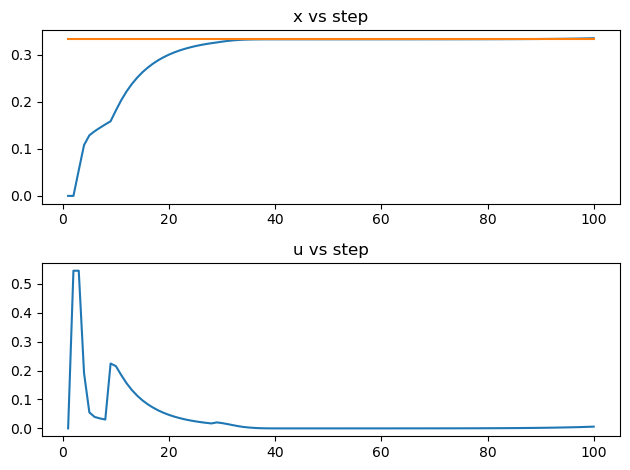

In [11]:
costMPCResultNoCost,xMPCResultNoCost,uMPCResultNoCost,controlAmountMPCResultNoCost = MPC();
println(costMPCResultNoCost);
println(xMPCResultNoCost);
println(uMPCResultNoCost);
println(controlAmountMPCResultNoCost);
data331 = [controlAmountMPCResultNoCost getTimeXeqReached(xMPCResultNoCost)]

clf(); #required for vscode on mac 
fig = plt.figure();

ax1 = fig.add_subplot(2, 1, 1);
ax1.title.set_text("x vs step");
plt.plot(range(1, 100), xMPCResultNoCost);
plt.plot(range(1, 100), xEquilibrium .* ones(100));

ax2 = fig.add_subplot(2, 1, 2);
ax2.title.set_text("u vs step");
plt.plot(range(1, 100), uMPCResultNoCost);

fig.tight_layout();
show()
gcf()

<h3> 3.3.2 Model predictive control with cost constraints </h3>

999.3003968087544
[0.0, 0.0, 0.010000000997175715, 0.020385002021275175, 0.031138070834365313, 0.04223815771557262, 0.05366007568417153, 0.06537456909684093, 0.07734847764993615, 0.08954499962676489, 0.10192405447599551, 0.11444274061810758, 0.12705587999350232, 0.13971663656909156, 0.15237719211102826, 0.1649894593407354, 0.17750581029430496, 0.18987979662426982, 0.20206683872335612, 0.21402484400328917, 0.21785509096801337, 0.22162871938890227, 0.2253422619605735, 0.22899250479628522, 0.23257649493730778, 0.2360915457765998, 0.23953524035489143, 0.24290543266374162, 0.24620024690723788, 0.24941807500943097, 0.25255757233242104, 0.25561765184170776, 0.25859747683815315, 0.2614964524205987, 0.26431421584220505, 0.2670506259250012, 0.2697057516920795, 0.2722798604234352, 0.27660575568333723, 0.28366738782454665, 0.28578067850075634, 0.2920451457647538, 0.2979067218329532, 0.30296153524782, 0.3073342070302651, 0.3111207516187482, 0.3144035567407067, 0.3172526899758653, 0.3197270717798577

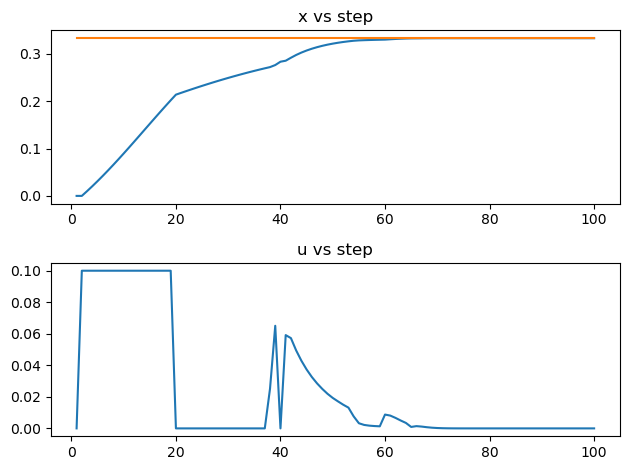

In [12]:
function MPCWithCostLimit()
    t = collect(2:100) #eixo x
    loopCount = 100
    uMPC = Array{Float64}(undef, loopCount)
    xMPC = Array{Float64}(undef, loopCount)
    uMPC[1] = 0
    xMPC[1] = 0
    costFunctionValue = 0
    sumU = 0

    for i in t
        ################ optimization routine #####################
        m = Model(Ipopt.Optimizer);
        set_silent(m);
        movingTimeHorizon = 10; #prediction window
        @variable(m, xMPCLocal[1:movingTimeHorizon] >= xMPC[i-1]);        
        @variable(m, uMPCLocal[1:movingTimeHorizon] >= 0);
        @constraint(m, xMPCLocal[1] == xMPC[i]) #initial point
        @constraint(m, xMPCLocal[10] == xEquilibrium) #initial point
        @constraint(m, uMPCLocal[1] == uMPC[i]) #initial point
        ################## cost limit #######################
        @constraint(m, uMPCLocal .<= 0.1) #initial point
        @constraint(m, sum(uMPCLocal) + sumU <= 2.5) #initial point
        #####################################################
        for t in 1:movingTimeHorizon-1
            @constraint(m, xMPCLocal[t+1] == xMPCLocal[t] + β1*uMPCLocal[t]*(1 - xMPCLocal[t]) + β2*(1 - xMPCLocal[t])*xMPCLocal[t] - δ*xMPCLocal[t]);
        end
        @objective(m, Min, sum(
            uMPCLocal .* uMPCLocal .+ (xMPCLocal .- xEquilibrium).^2 .+ λ
        ));
        optimize!(m);
        #############################################################
        uMPC[i] = JuMP.value.(uMPCLocal)[2]
        xMPC[i] = xMPC[i - 1] + β1*uMPC[i - 1]*(1 - xMPC[i - 1]) + β2*(1 - xMPC[i - 1])*xMPC[i - 1] - δ*xMPC[i - 1]
        costFunctionValue += JuMP.objective_value.(m)
        sumU += uMPC[i] 
    end

    return costFunctionValue, xMPC, uMPC, sum(uMPC);
end;

costMPCResultWithCost,xMPCResultWithCost,uMPCResultWithCost,controlAmountMPCResultWithCost = MPCWithCostLimit();
println(costMPCResultWithCost);
println(xMPCResultWithCost);
println(uMPCResultWithCost);
println(controlAmountMPCResultWithCost);
data332 = [controlAmountMPCResultWithCost, getTimeXeqReached(xMPCResultWithCost)]

clf(); #required for vscode on mac 
fig = plt.figure();

ax1 = fig.add_subplot(2, 1, 1);
ax1.title.set_text("x vs step");
plt.plot(range(1, 100), xMPCResultWithCost);
plt.plot(range(1, 100), xEquilibrium .* ones(100));

ax2 = fig.add_subplot(2, 1, 2);
ax2.title.set_text("u vs step");
plt.plot(range(1, 100), uMPCResultWithCost);

fig.tight_layout();
show()
gcf()

<h3> 3.4 Uncertainties </h3>

<h3> 3.4.1 Optimal control with uncertainties </h3>

In [13]:
function optimalControlWithUncertanties()
    m = Model(Ipopt.Optimizer);
    set_silent(m);
    numberOfIterations = 200;
    @variable(m, xOptimalControl[1:numberOfIterations] >= 0);        
    @variable(m, uOptimalControl[1:numberOfIterations] >= 0);
    @variable(m, t1[1:numberOfIterations] >= 0);
    @variable(m, t2[1:numberOfIterations] >= 0);
    @variable(m, t3[1:numberOfIterations] >= 0);

    for t in 1:numberOfIterations-1
        @constraint(
            m, 
            xOptimalControl[t+1] == xOptimalControl[t] 
            + β1*uOptimalControl[t]*(1 - xOptimalControl[t]) - ρβ1*(β1*uOptimalControl[t]*(1 - xOptimalControl[t]))
            + β2*(1 - xOptimalControl[t])*xOptimalControl[t] - ρβ2*(1 - xOptimalControl[t])*xOptimalControl[t] 
            - (δ*xOptimalControl[t] - ρδ*(δ*xOptimalControl[t]))
        );
    end

    @constraint(m, sum(xOptimalControl) >= 0);
    @constraint(m, sum(uOptimalControl) >= 0);
    @constraint(m, xOptimalControl[1] == 0) #initial point
    @constraint(m, xOptimalControl[200] == xEquilibrium) #final point

    @objective(m, Min, sum(
        uOptimalControl .^2 .+ (xOptimalControl .- xEquilibrium).^2 .+ λ
    ));
    optimize!(m);
    return JuMP.objective_value.(m), JuMP.value.(xOptimalControl), JuMP.value.(uOptimalControl), sum(JuMP.value.(uOptimalControl))
end;

13.736652085184138
[8.299344638756079e-41, 0.030558169989827313, 0.057434585427295896, 0.0811950749639536, 0.10228992215834218, 0.12108346899053188, 0.13787491412453176, 0.15291321308924685, 0.16640794266587414, 0.17853735148884037, 0.18945441584846853, 0.19929145990209493, 0.20816372847159653, 0.21617218587022546, 0.22340573593217292, 0.2299430042227449, 0.23585378537846755, 0.24120023152281406, 0.24603783832218515, 0.2504162712012395, 0.25438006396722196, 0.25796921452243243, 0.2612196967197222, 0.2641639032064185, 0.26683103092855565, 0.2692474185575, 0.27143684325786077, 0.2734207827952834, 0.2752186478799225, 0.27684798877834343, 0.27832467954566825, 0.2796630826880036, 0.2808761966304094, 0.2819757880137002, 0.28297251055592165, 0.28387601197753737, 0.2846950302925904, 0.28543748060323587, 0.28611053339580594, 0.28672068521809085, 0.2872738225159972, 0.2877752793201876, 0.28822988939734256, 0.2886420334144341, 0.2890156816063315, 0.28935443238595776, 0.289661547291061, 0.28993998

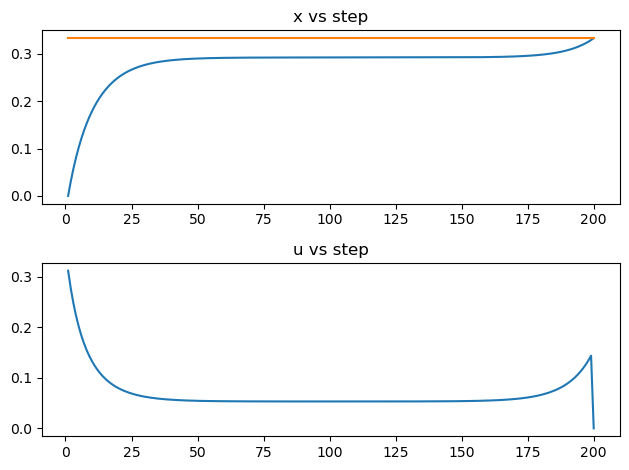

In [14]:
####### exporting variables for further analysis ########
costOptimalControlWithUncertantiesResult, xOptimalControlWithUncertantiesResult, uOptimalControlWithUncertantiesResult, controlAmountOptimalControlWithUncertantiesResult = optimalControlWithUncertanties()
println(controlAmountOptimalControlWithUncertantiesResult)
println(xOptimalControlWithUncertantiesResult)

##### simple plot #######
clf(); #required for vscode on mac 
fig = plt.figure();

ax1 = fig.add_subplot(2, 1, 1);
ax1.title.set_text("x vs step");
plt.plot(range(1, 200), xOptimalControlWithUncertantiesResult);
plt.plot(range(1, 200), xEquilibrium .* ones(200));

ax2 = fig.add_subplot(2, 1, 2);
ax2.title.set_text("u vs step");
plt.plot(range(1, 200), uOptimalControlWithUncertantiesResult);

fig.tight_layout();
show()
gcf()

<h3> 3.4.2 Model predictive control with uncertainties </h3>

In [30]:
function MPCWithUncertanties()
    t = collect(2:200) #eixo x
    loopCount = 200
    uMPC = Array{Float64}(undef, loopCount)
    xMPC = Array{Float64}(undef, loopCount)
    uMPC[1] = 0
    xMPC[1] = 0
    costFunctionSum = 0
    controlInputSum = 0

    for i in t
        ################ optimization routine #####################
        m = Model(Ipopt.Optimizer);
        set_silent(m);
        movingTimeHorizon = 10; #prediction window
        @variable(m, xMPCLocal[1:movingTimeHorizon] >= xMPC[i-1]);        
        @variable(m, uMPCLocal[1:movingTimeHorizon] >= 0);
        @constraint(m, xMPCLocal[1] == xMPC[i]) #initial point
        @constraint(m, xMPCLocal[10] == xEquilibrium) #initial point
        @constraint(m, uMPCLocal[1] == uMPC[i]) #initial point
        @constraint(m, uMPCLocal .<= 0.1)
        ####### have to force the setpoint constraint #########
        if (i >= 100)
            @constraint(m, xMPCLocal[2:10] .== xEquilibrium) #initial point
        end 
        #######################################################
        for t in 1:movingTimeHorizon-1
            @constraint(
                m, 
                xMPCLocal[t+1] == xMPCLocal[t] 
                + β1*uMPCLocal[t]*(1 - xMPCLocal[t]) - ρβ1*(β1*uMPCLocal[t]*(1 - xMPCLocal[t]))
                + β2*(1 - xMPCLocal[t])*xMPCLocal[t] - ρβ2*(1 - xMPCLocal[t])*xMPCLocal[t] 
                - (δ*xMPCLocal[t] - ρδ*(δ*xMPCLocal[t]))
            );
        end
        @objective(m, Min, sum(
            uMPCLocal .* uMPCLocal .+ (xMPCLocal .- xEquilibrium).^2 .+ λ
        ));
        optimize!(m);
        #############################################################
        uMPC[i] = JuMP.value.(uMPCLocal)[2]
        xMPC[i] = xMPC[i - 1] + β1*uMPC[i - 1]*(1 - xMPC[i - 1]) + β2*(1 - xMPC[i - 1])*xMPC[i - 1] - δ*xMPC[i - 1]
        costFunctionSum += JuMP.objective_value.(m)
        controlInputSum += uMPC[i]
    end

    return costFunctionSum, xMPC, uMPC, controlInputSum;
end;

1000.391220720317
[0.0, 0.0, 0.010000000996644748, 0.0203850020201989, 0.031138070832441817, 0.042238157707991, 0.053660075674897695, 0.06537456908742326, 0.07734847764089581, 0.08954499961880802, 0.10192405446810558, 0.1144427406112924, 0.12705587998631573, 0.13971663655699157, 0.15237719209883974, 0.1649894593285099, 0.1775058102820942, 0.18987979661212484, 0.20206683871132655, 0.2140248619604878, 0.22571486099307203, 0.2371013764348594, 0.24815287284778165, 0.25884201126685163, 0.2691458144378642, 0.27904572733047917, 0.2885275794520817, 0.29758145872458397, 0.3062015090880867, 0.31438566551881497, 0.322135340821187, 0.3294550784595456, 0.33635218495858155, 0.3422271354129996, 0.34807282938817286, 0.3537988697638425, 0.3591747791627595, 0.3641907926711901, 0.36886318499296333, 0.3732087056364321, 0.37724434379334343, 0.3809871239283077, 0.3844539312136632, 0.3876613652929941, 0.39062562039501225, 0.39336238952292235, 0.3958867902858825, 0.39821330989208503, 0.4003557668623561, 0.402

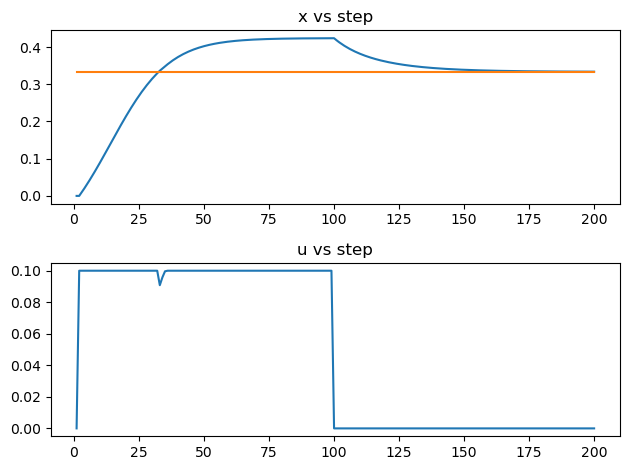

In [31]:
loopCount = 200
costMPCWithUncertantiesResult,xMPCWithUncertantiesResult,uMPCWithUncertantiesResult,controlAmountMPCWithUncertantiesResult = MPCWithUncertanties();
println(costMPCWithUncertantiesResult);
println(xMPCWithUncertantiesResult);
println(uMPCWithUncertantiesResult);
println(controlAmountMPCWithUncertantiesResult);

clf(); #required for vscode on mac 
fig = plt.figure();

ax1 = fig.add_subplot(2, 1, 1);
ax1.title.set_text("x vs step");
plt.plot(range(1, loopCount), transpose(xMPCWithUncertantiesResult));
plt.plot(range(1, loopCount), xEquilibrium .* ones(loopCount));

ax2 = fig.add_subplot(2, 1, 2);
ax2.title.set_text("u vs step");
plt.plot(range(1, loopCount), transpose(uMPCWithUncertantiesResult));

fig.tight_layout();
show()
gcf()

## 4. Results and discussion ##

<h3> Results summary with no budget limit </h3>

In [17]:
data = [
    "3.1.X" "Optimal control";
    "3.2.X" "Optimal control with simplified cost function";
    "3.3.X" "Predictive control";
    "3.4.1" "Optimal control with uncertainties";
    "3.4.2" "Predictive with uncertainties";
]
pretty_table(data; header = ["Index", "Control technique"])

┌───────┬───────────────────────────────────────────────┐
│ Index │                             Control technique │
├───────┼───────────────────────────────────────────────┤
│ 3.1.X │                               Optimal control │
│ 3.2.X │ Optimal control with simplified cost function │
│ 3.3.X │                            Predictive control │
│ 3.4.1 │            Optimal control with uncertainties │
│ 3.4.2 │                 Predictive with uncertainties │
└───────┴───────────────────────────────────────────────┘


In [24]:
data = [
    "3.1.1" data311[1] data311[2];
    "3.2.1" data321[1] data321[2];
    "3.3.1" data331[1] data331[2];
]
pretty_table(data; header = ["Control type", "Amount of control (Σu)", "Iteration when Xeq is reached"])

┌──────────────┬────────────────────────┬───────────────────────────────┐
│ Control type │ Amount of control (Σu) │ Iteration when Xeq is reached │
├──────────────┼────────────────────────┼───────────────────────────────┤
│        3.1.1 │                2.77612 │                          55.0 │
│        3.2.1 │                3.33259 │                           2.0 │
│        3.3.1 │                3.23748 │                          32.0 │
└──────────────┴────────────────────────┴───────────────────────────────┘


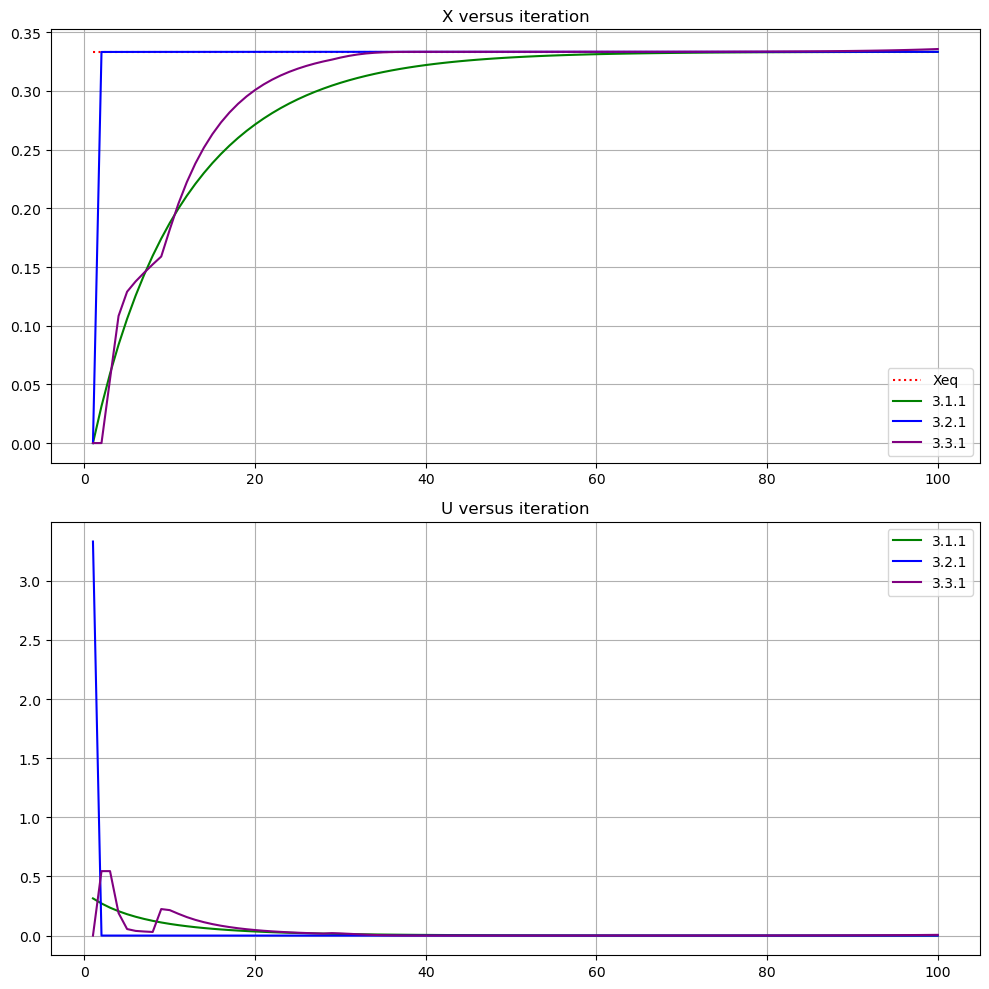

In [25]:
#Plots with no budget restriction 
t = 1:100
clf();
fig = plt.figure(figsize=(10,10));

ax1 = fig.add_subplot(2, 1, 1);
ax1.title.set_text("x vs step");
plt.plot(t, xEquilibrium .* ones(100), color="red", linestyle="dotted", label="Xeq")
plt.plot(t, xOptimalControlResult, color="green", label="3.1.1")
plt.plot(t, xFastestEquilibriumResult, color="blue", label="3.2.1")
plt.plot(t, xMPCResultNoCost, color="purple", label="3.3.1")

legend()
title("X versus iteration");
grid("on")
show()

ax2 = fig.add_subplot(2, 1, 2);
ax2.title.set_text("u vs step");
plt.plot(t, uOptimalControlResult, color="green", label="3.1.1")
plt.plot(t, uFastestEquilibriumResult, color="blue", label="3.2.1")
plt.plot(t, uMPCResultNoCost, color="purple", label="3.3.1")

fig.tight_layout();
legend()
title("U versus iteration");
grid("on")

show()
gcf()

<h3> Results summary with budget limit = 2.5 total and 0.1 instantaneous </h3>

In [26]:
data = [
    "3.1.2" data312[1] data312[2];
    "3.2.2" data322[1] data322[2];
    "3.3.2" data332[1] data332[2];
]
pretty_table(data; header = ["Control type", "Amount of control (Σu)", "Iteration when Xeq is reached"])

┌──────────────┬────────────────────────┬───────────────────────────────┐
│ Control type │ Amount of control (Σu) │ Iteration when Xeq is reached │
├──────────────┼────────────────────────┼───────────────────────────────┤
│        3.1.2 │                    2.5 │                          74.0 │
│        3.2.2 │                    2.5 │                          80.0 │
│        3.3.2 │                2.36402 │                          59.0 │
└──────────────┴────────────────────────┴───────────────────────────────┘


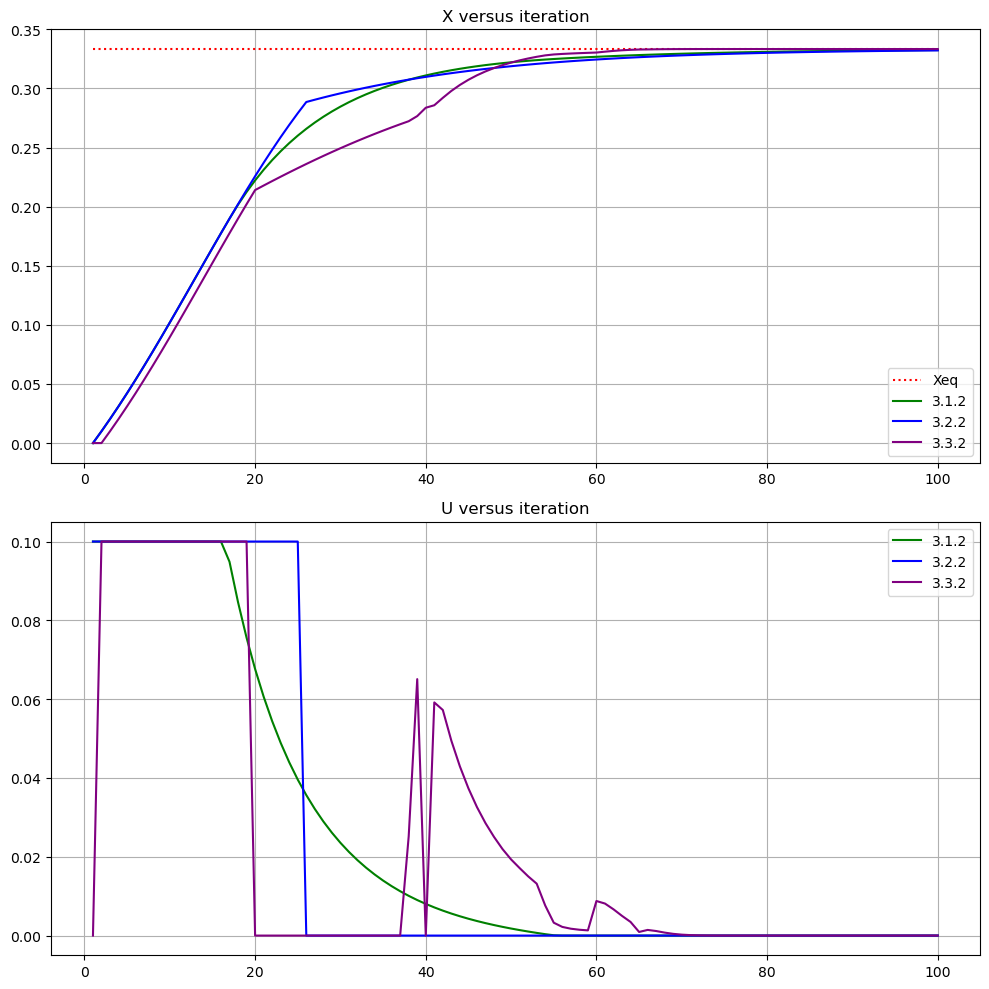

In [27]:
#Plots with budget constraints 
clf();
fig = plt.figure(figsize=(10,10));
t = 1:100
ax1 = fig.add_subplot(2, 1, 1);
ax1.title.set_text("x vs step");
plt.plot(t, xEquilibrium .* ones(100), color="red", linestyle="dotted", label="Xeq")
plt.plot(t, xOptimalControlLimitedCostsResult, color="green", label="3.1.2")
plt.plot(t, xFastestEquilibriumResultWithCostLimit, color="blue", label="3.2.2")
plt.plot(t, xMPCResultWithCost, color="purple", label="3.3.2")

legend()
title("X versus iteration");
grid("on")
show()

ax2 = fig.add_subplot(2, 1, 2);
ax2.title.set_text("u vs step");
plt.plot(t, uOptimalControlLimitedCostsResult, color="green", label="3.1.2")
plt.plot(t, uFastestEquilibriumResultWithCostLimit, color="blue", label="3.2.2")
plt.plot(t, uMPCResultWithCost, color="purple", label="3.3.2")

fig.tight_layout();
legend()
title("U versus iteration");
grid("on")

show()
gcf()

<h3> Results summary with uncertainties </h3>

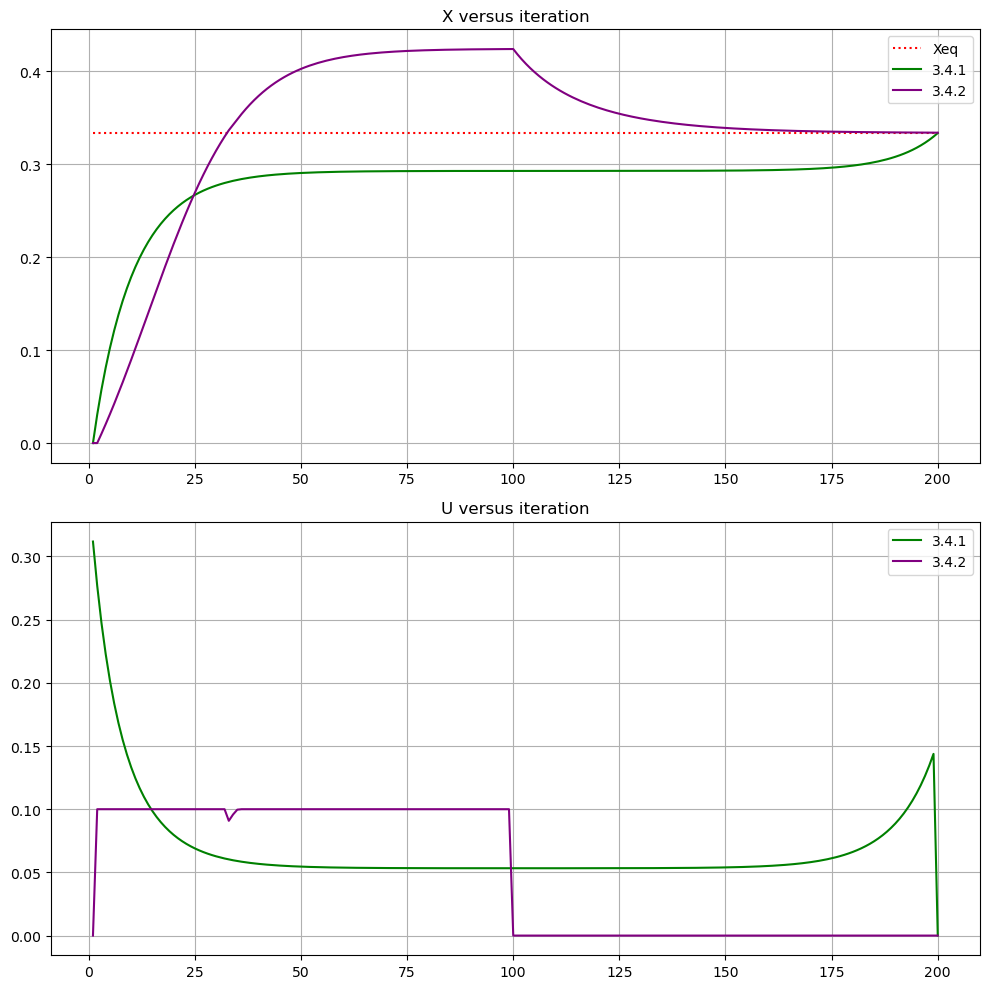

In [32]:
#Plots with budget uncertainties 
clf();
fig = plt.figure(figsize=(10,10));
t = 1:200
ax1 = fig.add_subplot(2, 1, 1);
ax1.title.set_text("x vs step");
plt.plot(t, xEquilibrium .* ones(200), color="red", linestyle="dotted", label="Xeq")
plt.plot(t, xOptimalControlWithUncertantiesResult, color="green", label="3.4.1")
plt.plot(t, xMPCWithUncertantiesResult, color="purple", label="3.4.2")

legend()
title("X versus iteration");
grid("on")
show()

ax2 = fig.add_subplot(2, 1, 2);
ax2.title.set_text("u vs step");
plt.plot(t, uOptimalControlWithUncertantiesResult, color="green", label="3.4.1")
plt.plot(t, uMPCWithUncertantiesResult, color="purple", label="3.4.2")

fig.tight_layout();
legend()
title("U versus iteration");
grid("on")

show()
gcf()

## 5. Conclusion ##
Based on the results presented above some conclusions can be drawn. 

All control models were able to reach equilibrium within 100 iterations when there were no uncertainties to the predefined constants.

However, some models accomplish this task faster and more efficient than others. From the tables presented, 2 cases should be analyzed: the first one when there are no budget-related constraints and the second when there is a budget limit [$\sum_{t=0}^{n}(u(t)) \leq 2.5$] and a maximum control amount at any given time [$u(t) \leq 0.1 \forall t$]

<b> In the first scenario, 3.2.1 is clearly the most efficient strategy if budget is not considered. That is because, even though it is 16% more expensive than 3.1.1, it reaches equilibrium 22.5 times faster. </b>

<b> Now, when there are budget constraints, 3.3.2 is clearly the most appropriate approach as it gets to equilibrium faster and accomplishes it while requiring less control input than the other strategies. </b>

Another important fact to be highlighted is that all control techniques struggle to deal with uncertainties in the estimation of  $\beta1$, $\beta2$ and $\delta$. The worst case scenario analysis, when these constants are underestimated and slow down the information spread dynamics, reveals that the model stabilizes around a different set-point other than  $X_{eq}$. To solve this issue, it is necessary for “force” $x(t)$ to be equals $X_{eq}$ in a given iteration by using the following constraint:

```julia
@constraint(m, xOptimalControl[200] == xEquilibrium)
```

Without these uncertainties, all models naturally converge to  $X_{eq}$  in order to minimize the cost function while the control input goes to 0 as expected.

## 6. Bibliography ##
1. Information Spread in a Social Media Age Modeling and Control, Michael Muhlmeyer and Shaurya Agarwal
2. Barg, Michael C. (2016) "Find, Process, and Share: An Optimal Control in the Vidale-Wolfe Marketing Model," CODEE Journal: Vol. 11, Article 1
3. https://www.youtube.com/watch?v=YwodGM2eoy4&t=366s&ab_channel=SteveBrunton